In [ ]:
#| include: false
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from causalnlp import CausalInferenceModel
from causalnlp import Autocoder

## What is the causal impact of a positive review on product views?

We use a semi-simulated dataset generated from [this repo](https://github.com/rpryzant/causal-text), which is available in the `sample_data` folder. The reviews and product types are real, while the outcomes (e.g., 1=product clicked, 0=not clicked) are simulated.

In [ ]:
#| notest
import pandas as pd

In [ ]:
#| notest
df = pd.read_csv('sample_data/music_seed50.tsv', sep='\t', on_bad_lines='skip')

In [ ]:
#| notest
df.head()

,index,id,rating,product,text,summary,price,T_true,C_true,Y_sim,negative,positive,T_ac
0,7,0001388703,1.0,mp3 music,buy the cd. do not buy the mp3 album. downlo...,Buy the CD. Do not buy the MP3.,13.01,0,0,0,0.548733,0.451267,0
1,8,0001388703,5.0,mp3 music,takes me back to my childhood!,Love it!,13.01,1,0,0,0.008373,0.991627,1
2,12,0001388703,5.0,audio cd,the passion and ingenuity of green's music is ...,No one like Keith Green,13.01,1,1,1,0.043761,0.956239,1
3,13,0001388703,5.0,mp3 music,keith's music is a timeless message. since hi...,Never Gets Old,13.01,1,0,1,0.038876,0.961124,1
4,15,0001377647,5.0,audio cd,i have fallen in love with john michael talbot...,Talbot a masterpiece,18.99,1,1,1,0.019828,0.980172,1


`Y_sim` is the simulated outcome indicating whether or not the product was clicked.  `C_true` is a categorical variable, where 1 is an audio CD and and 0 is something else (e.g., MP3).  In this dataset, outcomes were simulated such that `C_true` is a counfounding variable for this problem.

The treatment is whether or not the review is positive, which affects `Y_sim`.  Let's pretend we don't have a rating and need to infer this from text using the `Autocoder`. This can be done with:
```python
ac = Autocoder()
df = ac.code_sentiment(df['text'].values, df, batch_size=16, binarize=True)
df['T_ac'] = df['positive']
 ```
We've already created this as the `T_ac` column (along with the `positive` and `negative` columns), so invoking the above is not needed. Note that `T_ac` is an imperfect approximation of `T_true`. In CausalNLP, we can include the raw text as covariates to improve our estimates.

Let's fit the causal inference model.  We will adjust for both `C_true` and the raw text of the review to minimize bias from confounding. CausalNLP supports the following metalearners: S-Learner, T-Learner, X-Learner, and R-Learner. See [this paper](https://arxiv.org/abs/1706.03461) for more information on these. We will use the T-Learner as the metalearner here. By default, T-Learners use LightGBM classifiers with 31 leaves.  Let's increase the number of leaves to 500. In practice, you can supply a learner with hyperparameters that you've tuned beforehand to accurately predict the outcome.

In [ ]:
#| notest
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
cm = CausalInferenceModel(df, method='t-learner',
                    learner=LGBMClassifier(num_leaves=500),
                    treatment_col='T_ac', 
                    outcome_col='Y_sim', 
                    text_col='text',
                    include_cols=['C_true'])
cm.fit()

outcome column (categorical): Y_sim
treatment column: T_ac
numerical/categorical covariates: ['C_true']
text covariate: text
preprocess time:  1.118110179901123  sec
start fitting causal inference model
time to fit causal inference model:  10.667636632919312  sec


<causalnlp.causalinference.CausalInferenceModel>

### Average Treatment Effect (ATE)
We can calculate the overall average treatment effect (ATE) as follows:

In [ ]:
#| notest
cm.estimate_ate()

{'ate': 0.1309311542209525}

The overall ATE is an increase of 13 percentage points in probability. 

Unlike machine learning, there is no ground truth to which our estimate can be compared for causal inference on real-world datasets. Hoewver, since this is a simulated dataset, we can compare our estimate with the ground truth ATE of `0.1479` (14.79 percentage point change in outcome), and our estimate is close.

In [ ]:
#| notest
from collections import defaultdict
import numpy as np
def ATE_adjusted(C, T, Y):
    x = defaultdict(list)
    for c, t, y in zip(C, T, Y):
        x[c, t].append(y)

    C0_ATE = np.mean(x[0,1]) - np.mean(x[0,0])
    C1_ATE =  np.mean(x[1,1]) - np.mean(x[1,0])
    return np.mean([C0_ATE, C1_ATE])
print(ATE_adjusted(df.C_true, df.T_true, df.Y_sim))

0.14785542719890196


Such oracle estimates are not available for real-world datsets, as mentioned.  For real-world scenarios, we can, at least, evaluate the robustness of the ATE estimate to various data manipuations (i.e., sensitivity analysis or refutation).

In [ ]:
#| notest
cm.evaluate_robustness()

,Method,ATE,New ATE,New ATE LB,New ATE UB,Distance from Desired (should be near 0)
0,Placebo Treatment,0.130931,0.00477642,-0.00452705,0.0140799,0.00477642
0,Random Cause,0.130931,0.131122,0.122196,0.140049,0.000191267
0,Subset Data(sample size @0.8),0.130931,0.129383,0.117239,0.141528,-0.0015477
0,Random Replace,0.130931,0.130196,0.121209,0.139184,-0.000734766


Here, we see the distance from the desired value is near zero for each sensitivy analysis method , which is good.

### Conditional Average Treatment Effect (CATE)

We can also calculate the conditional average treatment effects (CATE). For instance, here is the treatment effect for those reviews that mention the word ``toddler.''

In [ ]:
#| notest
series = df['text']
cm.estimate_ate(df['text'].str.contains('toddler'))

{'ate': 0.15559234254638685}

### Individualized Treatment Effect (ITE)

We can easily predict the treatment effect for new or existing observations on a per-unit basis.  We just need to make sure the DataFrame supplied as input to `CausalInferenceModel.predict` contains the right columns. This can easily be checked with `CausalInferenceModel.get_required_columns`:

In [ ]:
#| notest
cm.get_required_columns()

['T_ac', 'C_true', 'text']

In [ ]:
#| notest
test_df = pd.DataFrame({
    'T_ac' : [1],
    'C_true' : [1],
    'text' : ['I love the music of Zamfir and his pan flute.']
      })

In [ ]:
#| notest
cm.predict(test_df)

array([[0.40062776]])

### Model Interpetability

We can use the `interpret` method to identify the attributes most predictive of individualized treatment effects across observations.  Features begnning with `v_` are word (or vocabulary) features.  We see that words like "music", "cd", and "love" in addition to the categorical attribute `C_true` (the known confounder which is 1 for audio CDs) are most predictive of *individualized* causal effects.

In [ ]:
#| notest
cm.interpret(plot=False, method='feature_importance')[1][:10]

v_music    0.079042
v_cd       0.066838
v_album    0.055168
v_like     0.040784
v_love     0.040635
C_true     0.039949
v_just     0.035671
v_song     0.035362
v_great    0.029918
v_heard    0.028373
dtype: float64

  0%|          | 0/1 [00:00<?, ?it/s]

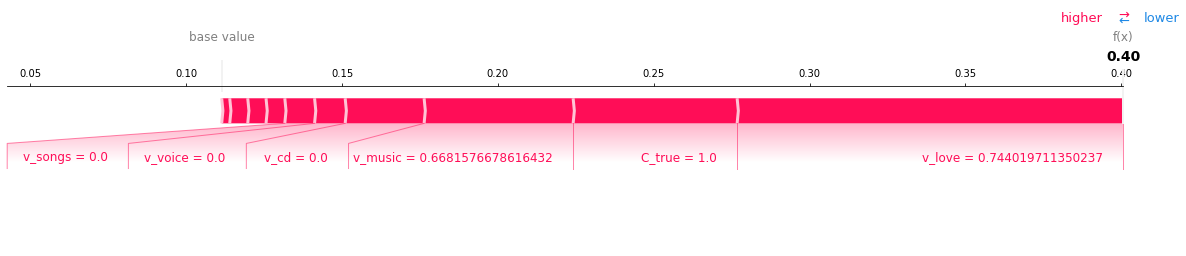

In [ ]:
#| notest
cm.explain(test_df, row_num=0)

In [ ]:
#| include: false
import pandas as pd

In [ ]:
#| include: false
df = pd.read_csv('sample_data/houses.csv')
fn = lambda x: 1 if x == 'Abnorml' else 0
df['treatment'] = df['SaleCondition'].apply(fn)

# estimate effect of foreclosures and short sales
# on sale price of homes > 2000 sq.
from causalnlp import CausalInferenceModel
cm = CausalInferenceModel(df, method='t-learner',
                   treatment_col='treatment', 
                   outcome_col='SalePrice',
                   ignore_cols=['Id', 'SaleCondition'])
cm.fit()
print(cm.estimate_ate(df['GrLivArea']>2000))
test_df = cm.df.iloc[[20]]
print(cm.predict(test_df))

outcome column (numerical): SalePrice
treatment column: treatment
numerical/categorical covariates: ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 

 ## What is the causal impact of having a PhD on making over $50K?
 
 > Text is Optional in CausalNLP
 
 Despite the "NLP" in the name, **CausalNLP** can be used for causal analyses on traditional tabular datasets with no text fields.
 
 Note: This dataset is from the early to mid 1990s, and we are using it as a toy dataset for demonstration purposes only.

In [ ]:
#| notest
import pandas as pd

In [ ]:
#| notest
df = pd.read_csv('sample_data/adult-census.csv')
df = df.rename(columns=lambda x: x.strip())
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x) 
filter_set = 'Doctorate'
df['treatment'] = df['education'].apply(lambda x: 1 if x in filter_set else 0)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,treatment
0,25,Private,178478,Bachelors,13,Never-married,Tech-support,Own-child,White,Female,0,0,40,United-States,<=50K,0
1,23,State-gov,61743,5th-6th,3,Never-married,Transport-moving,Not-in-family,White,Male,0,0,35,United-States,<=50K,0
2,46,Private,376789,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,15,United-States,<=50K,0
3,55,?,200235,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,50,United-States,>50K,0
4,36,Private,224541,7th-8th,4,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,El-Salvador,<=50K,0


In [ ]:
#| notest
from causalnlp import CausalInferenceModel
cm = CausalInferenceModel(df, method='t-learner',
                   treatment_col='treatment', 
                   outcome_col='class',
                   ignore_cols=['fnlwgt', 'education','education-num']).fit()

replaced ['<=50K', '>50K'] in column "class" with [0, 1]
outcome column (categorical): class
treatment column: treatment
numerical/categorical covariates: ['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
preprocess time:  0.4857158660888672  sec
start fitting causal inference model
time to fit causal inference model:  5.035430908203125  sec


Overall, the average treatment effect of having a PhD is an increase of 20 percentage points in the probability of making over $50K (with respect to this model and dataset):

In [ ]:
#| notest
cm.estimate_ate()

{'ate': 0.20340645077516034}

For those who have a Master's degree:

In [ ]:
#| notest
cm.estimate_ate(cm.df['education'] == 'Masters')

{'ate': 0.17672418257642838}

For those who are  high school dropouts:

In [ ]:
#| notest
cm.estimate_ate(cm.df['education'].isin(['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '12th']))

{'ate': 0.2586697863578173}

 ## What is the causal impact of a job training program on earnings?
 
 This is another example of causal inference on purely tabular data (no text).  Here, we will use the famous [LaLonde dataset](https://rdrr.io/cran/sbw/man/lalonde.html) from a job training study.

In [ ]:
#| notest
import pandas as pd
df = pd.read_csv('sample_data/lalonde.csv')
df.head()

,ID,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


Unlike other meta-learners that use LightGBM as a default, the S-Learner uses Linear Regression as the default base learner for regression problems, which is a model that is often  used for this dataset.  The ATE estimate is $1548, which indicates that the job training program had an overall positive effect.

In [ ]:
#| notest
from causalnlp import CausalInferenceModel
cm = CausalInferenceModel(df, method='s-learner',
                   treatment_col='treat', 
                   outcome_col='re78',
                   include_cols=['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75'])
cm.fit()
print(cm.estimate_ate()) # ATE estimate = $1548

outcome column (numerical): re78
treatment column: treat
numerical/categorical covariates: ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
preprocess time:  0.017691612243652344  sec
start fitting causal inference model
time to fit causal inference model:  0.0024728775024414062  sec
{'ate': 1548.2438019996084}
